# Yolact Installation Checker

Welcome, you can use this file to install Yolact and check if the installation was successfull or not and if your environment also supports your GPU.

It's easy, just follow the steps carefully.

**Topics:**
- [Installation](#installation)
  - Guide
  - Changes made in YOLACT Code
  - Manually Conda Env creation
  - Reinstallation of Nvidia-Driver
- [Imports](#import-needed-libraries)
- [Hardware Check](#hardware-check)
- [Test with COCO-Dataset](#test-with-coco-dataset)
- [Check Yolact Weight loading](#check-yolact-weight-loading)
- [Check Yolact Architectur](#check-yolact-architecture)
- [Input & Output Details](#input--output-details)

---
### Installation

---



1. **Install Yolact**<br>
    Get [Yolact from xXAI-botXx](https://github.com/xXAI-botXx/comfortable-yolact) (unofficial version of YOLACT)<br>
    ```bash
        git clone https://github.com/xXAI-botXx/comfortable-yolact.git
    ```

2. **Install important files on system**
    ```bash
    sudo apt-get install python-setuptools
    sudo apt-get install python3-dev
    sudo apt install python3-opencv
    sudo ubuntu-drivers autoinstall
    sudo apt install nvidia-cuda-toolkit
    sudo apt-get install protobuf-compiler
    ```

3. **Install Anaconda**
    - go to [anaconda website](https://conda.io/projects/conda/en/latest/user-guide/install/linux.html) and download anaconda
    - install anaconda with: ```sudo bash anaoconda-latest-Linux-x86_64.sh```
    - update conda: ```conda update conda```
    
4. **Set up a conda environment**
    - navigate to this project folder with bash (or use sudo wget)
    - then type:
        ```bash
        conda env create -f environment.yml
        ```
    - now you can activate and use the environment: 
        ```bash
        conda activate yolact
        ```

5. Use this file to check if your YOLACT-Model works properly



---
**You also can create the conda env manually:**

-> Not recommended, it's recommended to use the environment.yml file

``` bash
conda deactivate
conda env remove -n yolact -y

conda config --add channels nvidia
conda config --add channels conda-forge
conda config --add channels pytorch

conda create -n yolact python=3.12.3 -y
conda activate yolact
conda install pytorch -y -c pytorch -c nvidia
conda install torchvision -y -c pytorch -c nvidia
conda install torchaudio -y -c pytorch -c nvidia
conda install pytorch-cuda -y -c pytorch -c nvidia
conda install cudatoolkit -y
conda install cudnn -y
conda install Ipython[all] -y
conda install ipykernel -y
conda install opencv -y
conda install matplotlib-y
conda install mlflow -y
conda install numba -y
conda install scikit-image -y
conda install shapely -y
conda install jupyter -y
conda install git -y
conda install curl -y
conda install unzip -y
conda install pillow -y
conda install pycocotools -y
conda install pyqt -y
conda install graphviz -y 
conda install torchinfo -y
conda install torchview -y
conda install tensorboard -y
```






---
**Reinstallation of Nvidia-Driver:**

1. delete old versions:

   ```bash
   dpkg -l | grep -i nvidia
   sudo apt-get --purge remove "*cublas*" "cuda*"
   sudo apt-get remove --purge libnccl* 
   sudo apt-get remove --purge libnvidia* 
   sudo apt-get remove --purge libcudnn* 
   sudo apt-get --purge remove "*nvidia*"
   sudo apt-get update
   sudo apt-get autoremove
   sudo apt update
   sudo apt autoremove
   ```
   
2. Install Nvidia-Driver -> https://www.nvidia.de/Download/index.aspx?lang=de
   ```bash
   sudo ubuntu-drivers autoinstall
   ```

3. Install CUDA
   ```bash
   sudo apt install nvidia-cuda-toolkit
   ```

4. Reboot your system
   ```bash
   sudo reboot
   ```


5. Check installation
   ```bash
   nvidia-smi
   ```


---
### Import needed libraries

---

Here we already can see if all libraries can be imported or maybe is there still a problem.

Note that one import will be done later 'from train import train' because else it causes errors causing from system arguments which first can be created later.

In [1]:
# loading local libraries for Yolact
import sys

sys.path.append("./comfortable-yolact")

In [2]:
# Utils
import os
import json
import numpy as np
import cv2
import imutils
import matplotlib.pyplot as plt
from IPython.display import clear_output

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Import YOLACT
from yolact import Yolact
from data import Config, COCO_CLASSES, COCO_LABEL_MAP, cfg
from backbone import ResNetBackbone
from utils.augmentations import FastBaseTransform
from eval import prep_display

# Visualization
from torchinfo import summary as torchinfo_summary
from torchview import draw_graph

# For Input and Output Details
from data.coco import COCODetection, detection_collate
from utils.augmentations import SSDAugmentation
from layers.output_utils import postprocess

In [3]:
!python -V

Python 3.12.3


In [4]:
import platform

platform.platform()

'Linux-6.8.0-44-generic-x86_64-with-glibc2.39'

In [5]:
!pwd

/home/tobia/src/instance-segmentation


---
### Hardware Check

---

With the implementation it should be possible to see and use your GPU if available.<br>
Check if you can see your GPU.

In [6]:
# if torch.cuda.is_available():
#     device = torch.device("cuda")
# else:
#     device = torch.device("cpu")

In [7]:
# Check if a GPU is available
print(f"{'-'*32}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    print(f"GPU is available. Using {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available. Using CPU.")
print(f"{'-'*32}")

# Check the usage of the GPU with a simple CNN training
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model and move it to the device
model = SimpleCNN().to(device)

# Here we use the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# test train, for 1 epoch and only 1 batch
model.train()
for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    
    break 

print(f"{'-'*32}")
print("Training completed on", device)
print(f"{'-'*32}")

if device.type in ["gpu", "cuda"]:
    print("\n==> Congratulations! Your Environment can use your GPU!")
else:
    print("\n==> WARNING: Your Environment can NOT use a GPU. Maybe there is something wrong with your installation or you have no GPU or a unsupported GPU.")

--------------------------------
GPU is not available. Using CPU.
--------------------------------
--------------------------------
Training completed on cpu
--------------------------------

==> WARNING: Your Environment can NOT use a GPU. Maybe there is something wrong with your installation or you have no GPU or a unsupported GPU.


In [8]:
torch.cuda.is_available()

False

In [9]:
def cmd(command):
    """
    Executes a bash command, but only on linux systems
    """
    if sys.platform.startswith("linux"):
        os.system(command)
    else:
        print("Not a Linux system.")

cmd("nvidia-smi")

sh: 1: nvidia-smi: not found


---
### Test with COCO-Dataset

---

Here we make small test training with the COCO-Datatset.

To verify the GPU-Usage, please open an external terminal and run:
```bash
watch -n 1 nvidia-smi
```

**Download the COCO dataset**

```bash
cd ~/src/instance-segmentation
sh ./yolact/data/scripts/COCO.sh
```

Or remove the comment-sign (hashtag) and run the block below.

In [10]:
# !sh ./yolact/data/scripts/COCO.sh

**Download Pretrained Weights**

You can download the weights from [here](https://drive.google.com/file/d/1tvqFPd4bJtakOlmn-uIA492g2qurRChj/view), also see [their github repo](https://github.com/dbolya/yolact#training).

In [11]:
if not (os.path.exists("./weights") and os.path.isdir("./weights")):
    print("create weights folder...")
    os.mkdir("./weights")
else:
    print("weights folder already exists")

weights folder already exists


Now put the pth File inside the folder.

**Set Configurations**

for explanations see [here](./yolact/data/config.py)

In [12]:
activation_func = Config({
    'tanh':    torch.tanh,
    'sigmoid': torch.sigmoid,
    'softmax': lambda x: torch.nn.functional.softmax(x, dim=-1),
    'relu':    lambda x: torch.nn.functional.relu(x, inplace=True),
    'none':    lambda x: x,
})

In [13]:
data_config = Config({
    'name': 'COCO testdataset',

    # Training images and annotations
    'train_images': './data/coco/images/',
    'train_info':   './data/coco/annotations/instances_train2017.json',

    # Validation images and annotations.
    'valid_images': './data/coco/images/',
    'valid_info':   './data/coco/annotations/instances_val2017.json',

    # Whether or not to load GT. If this is False, eval.py quantitative evaluation won't work.
    'has_gt': True,

    # A list of names for each of you classes.
    'class_names': COCO_CLASSES,

    # COCO class ids aren't sequential, so this is a bandage fix. If your ids aren't sequential,
    # provide a map from category_id -> index in class_names + 1 (the +1 is there because it's 1-indexed).
    # If not specified, this just assumes category ids start at 1 and increase sequentially.
    'label_map': COCO_LABEL_MAP
})

In [14]:
BATCH_SIZE = 5

with open(data_config.train_info, "r") as json_file:
    DATA_SIZE = len(json.load(json_file)['images'])

ITERATIONS_PER_EPOCHE = (DATA_SIZE // BATCH_SIZE)

print(f"BATCH_SIZE = {BATCH_SIZE}\nDATA_SIZE = {DATA_SIZE}")
print(f"ITERATIONS_PER_EPOCHE = {ITERATIONS_PER_EPOCHE}");

BATCH_SIZE = 5
DATA_SIZE = 118287
ITERATIONS_PER_EPOCHE = 23657


In [15]:
resnet_transform = Config({
    'channel_order': 'RGB',
    'normalize': True,
    'subtract_means': False,
    'to_float': False,
})

In [16]:
backbone_config = Config({
    'name': 'ResNet101',
    'path': 'resnet101_reducedfc.pth',
    'type': ResNetBackbone,
    'args': ([3, 4, 23, 3],),
    'transform': resnet_transform,

    'selected_layers': list(range(1, 4)),
    'pred_scales': [[24], [48], [96], [192], [384]],
    'pred_aspect_ratios': [ [[1, 1/2, 2]] ]*5,

    'use_pixel_scales': True,
    'preapply_sqrt': False,
    'use_square_anchors': True,
})

In [17]:
fpn_config = Config({
    'num_features': 256,
    'interpolation_mode': 'bilinear',
    'num_downsample': 2,
    'use_conv_downsample': True,
    'pad': True,
    'relu_downsample_layers': False,
    'relu_pred_layers': True,
})

In [18]:
test_yolact_config = Config({

    'name': 'test_yolact_config',

    ############
    ### Data ###
    ############

    'dataset': data_config,
    'num_classes': len(data_config.class_names) + 1, # This should include the background class
    'max_size': 550,

    #    in SSD
    # Randomize hue, vibrance, etc.
    'augment_photometric_distort': True,
    # Have a chance to scale down the image and pad (to emulate smaller detections)
    'augment_expand': True,
    # Potentialy sample a random crop from the image and put it in a random place
    'augment_random_sample_crop': True,
    # Mirror the image with a probability of 1/2
    'augment_random_mirror': True,
    # Flip the image vertically with a probability of 1/2
    'augment_random_flip': False,
    # With uniform probability, rotate the image [0,90,180,270] degrees
    'augment_random_rot90': False,



    ########################
    ### Training Details ###
    ########################

    'max_iter': int(0.01*ITERATIONS_PER_EPOCHE), #800000,
    'lr': 1e-3,
    'momentum': 0.9,
    'freeze_bn': False,
    'fpn': fpn_config,

    'decay': 5e-4,
    'gamma': 0.1,
    'lr_steps': (280000, 600000, 700000, 750000),
    'lr_warmup_init': 1e-4,
    'lr_warmup_until': 500,

    #    backbone
    'backbone': backbone_config,

    #     scale loss
    'conf_alpha': 1,
    'bbox_alpha': 1.5,
    'mask_alpha': 0.4 / 256 * 140 * 140, 

    'use_semantic_segmentation_loss': True,
    'semantic_segmentation_alpha': 1,

    'use_mask_scoring': False,
    'mask_scoring_alpha': 1,

    'use_focal_loss': False,
    'focal_loss_alpha': 0.25,
    'focal_loss_gamma': 2,
    'focal_loss_init_pi': 0.01,




    #################
    ### Detection ###
    #################

    'max_num_detections': 100,
    'eval_mask_branch': True,
    
    'nms_top_k': 200,
    'nms_conf_thresh': 0.005,
    'nms_thresh': 0.5,

    'mask_type': 1,
    'mask_size': 6.125,
    'masks_to_train': 100,
    'mask_proto_src': 0,
    'mask_proto_net': [(256, 3, {'padding': 1})] * 3 + [(None, -2, {}), (256, 3, {'padding': 1})] + [(32, 1, {})],
    'mask_proto_bias': False,
    'mask_proto_prototype_activation': activation_func.relu,
    'mask_proto_mask_activation': activation_func.sigmoid,
    'mask_proto_coeff_activation': activation_func.tanh,
    'mask_proto_crop': True,
    'mask_proto_crop_expand': 0,
    'mask_proto_loss': None,
    'mask_proto_binarize_downsampled_gt': True,
    'mask_proto_normalize_mask_loss_by_sqrt_area': False,
    'mask_proto_reweight_mask_loss': False,
    'mask_proto_grid_file': 'data/grid.npy',
    'mask_proto_use_grid':  False,
    'mask_proto_coeff_gate': False,
    'mask_proto_prototypes_as_features': False,
    'mask_proto_prototypes_as_features_no_grad': False,
    'mask_proto_remove_empty_masks': False,
    'mask_proto_reweight_coeff': 1,
    'mask_proto_coeff_diversity_loss': False,
    'mask_proto_coeff_diversity_alpha': 1,
    'mask_proto_normalize_emulate_roi_pooling': True,
    'mask_proto_double_loss': False,
    'mask_proto_double_loss_alpha': 1,
    'mask_proto_split_prototypes_by_head': False,
    'mask_proto_crop_with_pred_box': False,
    'mask_proto_debug': False,

    'discard_box_width': 4 / 550,
    'discard_box_height': 4 / 550,

    'share_prediction_module': True,
    'ohem_use_most_confident': False,

    'use_class_balanced_conf': False,

    'use_sigmoid_focal_loss': False,

    'use_objectness_score': False,

    'use_class_existence_loss': False,
    'class_existence_alpha': 1,

    'use_change_matching': False,

    'extra_head_net': [(256, 3, {'padding': 1})],

    'head_layer_params': {'kernel_size': 3, 'padding': 1},

    'extra_layers': (0, 0, 0),

    'positive_iou_threshold': 0.5,
    'negative_iou_threshold': 0.4,

    'ohem_negpos_ratio': 3,

    'crowd_iou_threshold': 0.7,
    
    'force_cpu_nms': True,

    'use_coeff_nms': False,

    'use_instance_coeff': False,
    'num_instance_coeffs': 64,

    'train_masks': True,
    'train_boxes': True,
    'use_gt_bboxes': False,

    'preserve_aspect_ratio': False,

    'use_prediction_module': False,

    'use_yolo_regressors': False,
    
    'use_prediction_matching': False,

    'delayed_settings': [],

    'no_jit': False,

    'mask_dim': None,

    'use_maskiou': True,
    
    'maskiou_net': [(8, 3, {'stride': 2}), (16, 3, {'stride': 2}), (32, 3, {'stride': 2}), (64, 3, {'stride': 2}), (128, 3, {'stride': 2})],

    'discard_mask_area': 5*5,

    'maskiou_alpha': 25,
    'rescore_mask': True,
    'rescore_bbox': False,
    'maskious_to_train': -1,
})

**Train and test on COCO dataset**

(also could use the model and program train by self)

In [19]:
# cmd("python ./yolact/train.py --help")

In [20]:
sys.argv = ['train.py', 
            # '--config=test_yolact_config', 
            f'--batch_size={BATCH_SIZE}', 
            '--log_folder=./log/',
            '--save_folder=./weights/',
            '--cuda=True']
            #'--log_gpu']

cfg = test_yolact_config.copy()

from train import train
train(cfg, should_compute_validation_map=False)

No GPUs detected. Exiting...


SystemExit: -1

/home/tobia/anaconda3/envs/yolact/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Find Log Entry

-> Not so important

In [ ]:
log_entries = []
latest_session = 0
latest_epoch = 0
latest_iteration = 0

with open("./log/test_yolact_config.log", "r") as log_file:
    for line in log_file.readlines():
        cur_line = json.loads(line)
        log_entries += [cur_line]
        if cur_line["session"] > latest_session:
            latest_session = cur_line["session"]

# get latest epoch
for cur_entry in log_entries:
    if cur_entry["session"] == latest_session and cur_entry["type"] == "train":
        if cur_entry["data"]["epoch"] > latest_epoch:
            latest_epoch = cur_entry["data"]["epoch"]

# get latest iteration
for cur_entry in log_entries:
    if cur_entry["session"] == latest_session \
                        and cur_entry["type"] == "train" \
                        and cur_entry["data"]["epoch"] == latest_epoch:
        if cur_entry["data"]["iter"] > latest_iteration:
            latest_iteration = cur_entry["data"]["iter"]

# find right entry
for cur_entry in log_entries:
    if cur_entry["session"] == latest_session \
                        and cur_entry["type"] == "train" \
                        and cur_entry["data"]["epoch"] == latest_epoch \
                        and cur_entry["data"]["iter"] == latest_iteration:
        print(f'Session: {cur_entry["session"]}\nEpoch: {cur_entry["data"]["epoch"]}\nIteration: {cur_entry["data"]["iter"]}')
        break

Session: 125
Epoch: 0
Iteration: 235


---
### Check Yolact Weight loading

---

Here we will create a new random Yolact Model. Then we will load it free times an inference on the same image. It works if the result is always the same. The result will look not good, that is fine for now, it is untrained and only the functionality was approved!

**Load an Test Image**

torch.Size([425, 640, 3])
torch.Size([1, 3, 550, 550])


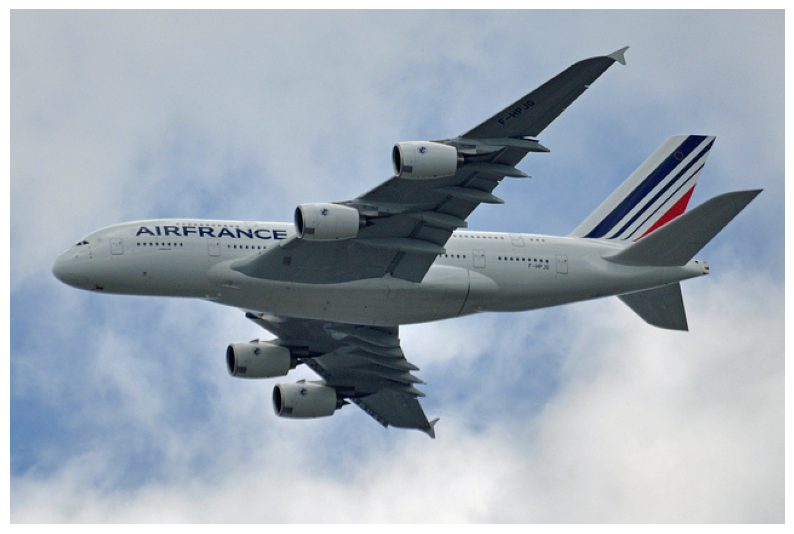

In [ ]:
img_path = f"./res/test.jpg"

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_ = image
# image = imutils.resize(image, width=512)
image = torch.from_numpy(image).cuda().float()
print(image.shape)

prepared_image = FastBaseTransform()(image.unsqueeze(0))
print(prepared_image.shape)

plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(image_);

**Create a model, save the weights and load them 3 times**

In [ ]:
def calculate_difference_between_weights(weights:list):
    differences = []
    for cur_weights_1 in weights:
        cur_differences = []
        for cur_weights_2 in weights:
            for (weight_name_1, weight_value_1), (weight_name_2, weight_value_2) in zip(cur_weights_1.items(), cur_weights_2.items()):
                diff = torch.abs(weight_value_1 - weight_value_2)
                sum_diff = torch.sum(diff).item()
                cur_differences += [sum_diff]
        differences += [cur_differences]
    return np.sum(differences)

Successfully created a random new YOLACT-Model and saved the weights of the model!

Congratulations!
Your implementation works and is ready to segment!


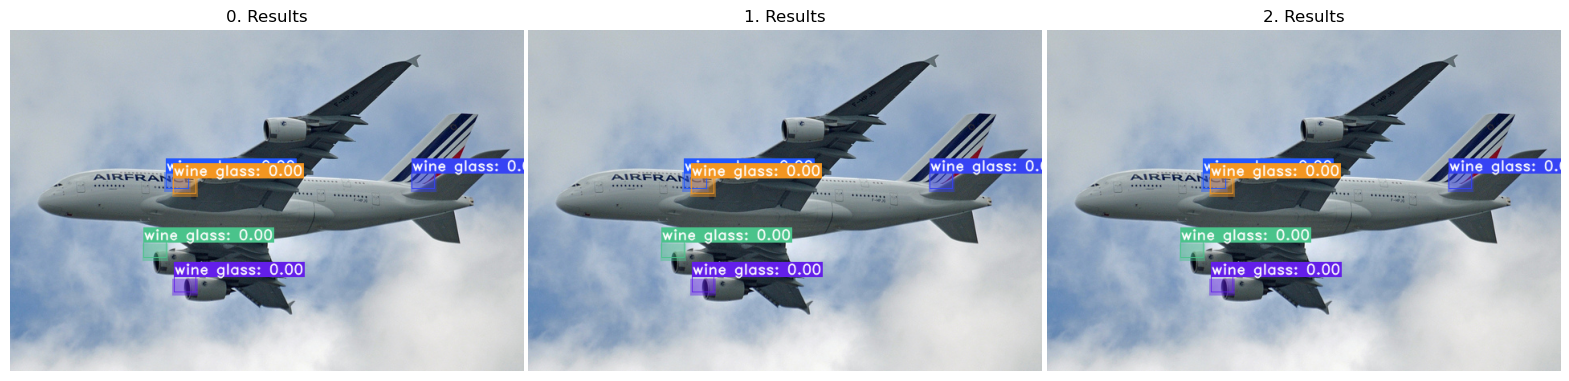

In [ ]:
NAME = "mask-rcnn test"
GPU_COUNT = 1
IMAGES_PER_GPU = 1
NUM_CLASSES = 2
# BACKBONE = "resnet50"
# IMAGE_MIN_DIM = 800
# IMAGE_MAX_DIM = 1024

CLASS_NAMES = ['BG', 'FG']
TEST_MODEL_PATH = "./weights/test_model.pth"

# create new model with random weights
model = Yolact()
model.train()
# load pretrained backbone
# model.init_weights(backbone_path="./weights/" + "resnet101_reducedfc.pth")
# init model
model.freeze_bn()
model(torch.zeros(1, 3, cfg.max_size, cfg.max_size).cuda())
model.freeze_bn(True)
# save weights
model.save_weights(TEST_MODEL_PATH)

if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

clear_output()

# check creation of weights
if os.path.exists(TEST_MODEL_PATH) and os.path.isfile(TEST_MODEL_PATH):
    print("Successfully created a random new YOLACT-Model and saved the weights of the model!\n")

    # prepare visualization
    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(20, 5))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.01, hspace=None)

    # load the created random weights 3 times
    weights = []
    differences = []
    for i in range(3):
        # create new yolact model and load weights
        model = Yolact()
        model.eval()
        model.load_weights(TEST_MODEL_PATH)
        model.cuda()

        # create and visualize the results
        preds = model(prepared_image)

        img_numpy = prep_display(preds, image, None, None, undo_transform=False,
                                 configuration=cfg)

        ax[i].set_title(f"{i}. Results")
        ax[i].axis("off")
        ax[i].imshow(img_numpy)
        # visualize.display_instances(image, result['rois'], result['masks'], result['class_ids'], CLASS_NAMES, result['scores'],
        #                             ax=ax[i], show_mask=True, show_bbox=True)
        weights += [model.state_dict()]

    # clear_output()

    # detect differences between the models
    complete_sum_difference = calculate_difference_between_weights(weights)
    if complete_sum_difference == 0.0:
        print("Congratulations!\nYour implementation works and is ready to segment!")
    else:
        print("Difference detected. Your Yolact seem to have an problem.")
        print("Check if you correctly applied all steps of the installation.")
        print("\nMore detail of differences:")
        print("Absolute Weight Differences:", complete_sum_difference)
        print("Comparison: Weight 1, Weight 2, Weight 3")
        for idx in range(len(differences)):
            print(f"Weight {idx+1}: {differences[idx]}")

    # try to remove the test model file
    try:
        os.remove(TEST_MODEL_PATH)
    except Exception:
        print(f"Wasn't able to delete the test model at: {TEST_MODEL_PATH}")

    plt.show();
else:
    print("There was a failure with creation and saving the weights of your YOLACT model. Please check if your installation is correct and restart and try again")

---
### Check Yolact Architectur

---

Here you can inspect the architecture of Yolact. Only if needed. 

In [ ]:
# Load the Image
img_path = f"./res/test.jpg"
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Resizing
resized_image = cv2.resize(image, (cfg.max_size, cfg.max_size))

# Add padding if the image is too small
pad_width = (cfg.max_size - resized_image.shape[1]) // 2
pad_height = (cfg.max_size - resized_image.shape[0]) // 2
padded_image = cv2.copyMakeBorder(resized_image, pad_height, pad_height, pad_width, pad_width, cv2.BORDER_CONSTANT, value=0)

# Convert the image to PyTorch tensor format
final_tensor = torch.tensor(padded_image).permute(2, 0, 1).unsqueeze(0)
final_tensor = final_tensor.float()    # .cuda()

final_tensor.size()

torch.Size([1, 3, 550, 550])

In [ ]:
model = Yolact()
model.eval()

In [ ]:
print(model)

Yolact(
  (backbone): ResNetBackbone(
    (layers): ModuleList(
      (0): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (1): Bottleneck(
          (conv1): Conv2d(256, 64, ker

In [ ]:
torchinfo_summary(model, input_size=(1, 3, 550, 550))

Layer (type:depth-idx)                             Output Shape              Param #
├─FastMaskIoUNet: 1-1                              --                        --
│    └─Sequential: 2-1                             --                        --
│    │    └─Conv2d: 3-1                            --                        80
│    │    └─ReLU: 3-2                              --                        --
│    │    └─Conv2d: 3-3                            --                        1,168
│    │    └─ReLU: 3-4                              --                        --
│    │    └─Conv2d: 3-5                            --                        4,640
│    │    └─ReLU: 3-6                              --                        --
│    │    └─Conv2d: 3-7                            --                        18,496
│    │    └─ReLU: 3-8                              --                        --
│    │    └─Conv2d: 3-9                            --                        73,856
│    │    └─ReLU: 3-1

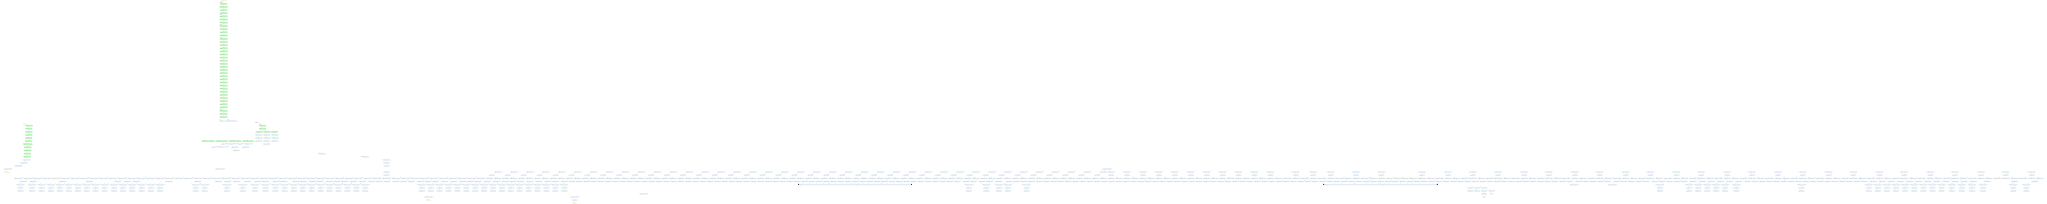

In [ ]:
model_graph = draw_graph(model, 
                        input_size=([1, 3, cfg.max_size, cfg.max_size]), 
                        device='cuda', 
                        graph_name='YOLACT',
                        expand_nested=True,
                        hide_inner_tensors=True,
                        hide_module_functions=True)
model_graph.visual_graph

In [ ]:
model_graph = draw_graph(model, 
                        input_size=([1, 3, cfg.max_size, cfg.max_size]), 
                        device='cuda', 
                        graph_name='YOLACT',
                        expand_nested=True,
                        hide_inner_tensors=False,
                        hide_module_functions=False)
model_graph.visual_graph

---
### Input & Output Details

---

Here is nothing to check, just informations about the exact input expected from the yolact network and the output given from the net.

**Input**

Format:
```python
list( 
    # Input Images
        # amount as given from BATCH_SIZE
        # shape of single Tensor: [3, 550, 550] bzw. [1, 3, 550, 550]
    list(torch.Tensor, torch.Tensor, ...),

    # Bounding Boxes + Class, Masks/Labels, Number of crowd objects
    list(
            # amount = BATCH_SIZE
            # shape of single Tensor: [amount_of_masks, 5]
                # x_min, y_min, x_max, y_max, class label
        list(torch.Tensor, torch.Tensor, ...),
        
            # amount = BATCH_SIZE
            # shape of single Tensor: [amount_of_masks, img_width, img_height]
        list(torch.Tensor, torch.Tensor, ...),

            # amount = BATCH_SIZE
        list(numpy.int64, numpy.int64, ...)
    )
)
```

The masks are a torch.Tensor, where every object mask has an index and the size of the original image. 0 is background and 1 is the object.

In [ ]:
MEANS = (103.94, 116.78, 123.68)
dataset = COCODetection(image_path=cfg.dataset.train_images,
                            info_file=cfg.dataset.train_info,
                            transform=SSDAugmentation(MEANS))

data_loader = torch.utils.data.DataLoader(dataset, BATCH_SIZE,
                                  num_workers=1,
                                  shuffle=True, collate_fn=detection_collate,
                                  pin_memory=True,
                                  generator=torch.Generator(device='cuda'),)

for data in data_loader:
    # print types and shapes
    print(f"\n{'-'*32}\nInput Type: {type(data)}")
    print(f"Input Len: {len(data)}")

    for idx in range(len(data)):
        print(f"\n    {idx+1}. Input Type: {type(data[idx])}")
        print(f"       Input Len: {len(data[idx])}")

        for idx_2 in range(len(data[idx])):
            print(f"        {idx_2+1}. Input Type: {type(data[idx][idx_2])}")
            if type(data[idx][idx_2]) == torch.Tensor:
                print(f"           Input Len: {data[idx][idx_2].size()}")
                print(f"           Input Type: {data[idx][idx_2].dtype}")
            else:
                print(f"           Input Len: {len(data[idx][idx_2])}")
                for idx_3 in range(len(data[idx][idx_2])):
                    print(f"            {idx_3+1}. Input Type: {type(data[idx][idx_2][idx_3])}")
                    if type(data[idx][idx_2][idx_3]) == torch.Tensor:
                        print(f"               Input Len: {data[idx][idx_2][idx_3].size()}")
                        print(f"               Input Type: {data[idx][idx_2][idx_3].dtype}")
                    elif type(data[idx][idx_2][idx_3]) == np.int64:
                        print(f"               Input Len: {data[idx][idx_2][idx_3].shape}")
                    else:
                        print(f"               Input Len: {len(data[idx][idx_2][idx_3])}")

    # print examples
    print(f"\n\nImage:\n{data[0][0]}")
    print(f"\nBox:\n{data[1][0][0]}")
    print(f"\nMask:\n{data[1][1][0]}")
    print(f"\nNumber of Crowd Objects:\n{data[1][2][0]}")
    break

loading annotations into memory...


Done (t=10.32s)
creating index...
index created!

--------------------------------
Input Type: <class 'list'>
Input Len: 2

    1. Input Type: <class 'list'>
       Input Len: 5
        1. Input Type: <class 'torch.Tensor'>
           Input Len: torch.Size([3, 550, 550])
           Input Type: torch.float32
        2. Input Type: <class 'torch.Tensor'>
           Input Len: torch.Size([3, 550, 550])
           Input Type: torch.float32
        3. Input Type: <class 'torch.Tensor'>
           Input Len: torch.Size([3, 550, 550])
           Input Type: torch.float32
        4. Input Type: <class 'torch.Tensor'>
           Input Len: torch.Size([3, 550, 550])
           Input Type: torch.float32
        5. Input Type: <class 'torch.Tensor'>
           Input Len: torch.Size([3, 550, 550])
           Input Type: torch.float32

    2. Input Type: <class 'list'>
       Input Len: 3
        1. Input Type: <class 'list'>
           Input Len: 5
            1. Input Type: <class 'torch.Tensor'>


<!-- 
To apply the right format you can use a functionality from YOLACT or you can make it manually:

```python
from utils.augmentations import FastBaseTransform

# Load Image
img_path = f"./res/test.jpg"
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert to Torch Tensor
image = torch.from_numpy(image).cuda().float()

# Bring the Tensor in right Format
prepared_image = FastBaseTransform()(image.unsqueeze(0))
```


Or alternativly:

```python
img_path = f"./res/test.jpg"
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Resizing
resized_image = cv2.resize(image, (cfg.max_size, cfg.max_size))

# Add padding if the image is too small
pad_width = (cfg.max_size - resized_image.shape[1]) // 2
pad_height = (cfg.max_size - resized_image.shape[0]) // 2
padded_image = cv2.copyMakeBorder(resized_image, pad_height, pad_height, pad_width, pad_width, cv2.BORDER_CONSTANT, value=0)

# Convert the image to PyTorch tensor format
final_tensor = torch.tensor(padded_image).permute(2, 0, 1).unsqueeze(0)
final_tensor = final_tensor.cuda().float()
```

**Output Unprocessed**

```python
list(
    dict(
        "net": *NETWORK
        "detection": dict(
            "class": torch.Size([PREDICTIONS*]),
            "boxes": torch.Size([PREDICTIONS*, 4],
            "score": torch.Size([PREDICTIONS*]),
            "proto": torch.Size([138, 138, 32]),
            "mask": torch.Size([PREDICTIONS*, 32])
        )
    ),
    ...
)
```

For every proto-mask there is a coefficient which tells how much information it holds for the segmentation and this for every mask.<br>And so there are so many entires as objects detected and every of these entries has 32 entries with one value for every prot-mask.

138x138 is the size of the proto-mask size.

In [ ]:
img_path = f"./res/test.jpg"
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = torch.from_numpy(image).cuda().float()

prepared_image = FastBaseTransform()(image.unsqueeze(0))

with torch.no_grad():
    model = Yolact()
    model.eval()
    model.init_weights("./weights/resnet101_reducedfc.pth")
    # model.load_weights("./weights/resnet101_reducedfc.pth")
    model.cuda()

    preds = model(prepared_image)

    print(f"\nResult Type: {type(preds[0])}")
    print(f"Result Keys: {preds[0].keys()}")
    print(f"\nDetection Keys: {preds[0]['detection'].keys()}")

    print(f"Box Size: {preds[0]['detection']['box'].size()}")
    print(f"Class Size: {preds[0]['detection']['class'].size()}")
    print(f"Score Size: {preds[0]['detection']['score'].size()}")
    print(f"Proto Size: {preds[0]['detection']['proto'].size()}")
    print(f"Mask Size: {preds[0]['detection']['mask'].size()}")

    print(f"\n\nBox:\n{preds[0]['detection']['box']}")
    print(f"\nClass:\n{preds[0]['detection']['class']}")
    print(f"\nScore:\n{preds[0]['detection']['score']}")
    print(f"\nProto:\n{preds[0]['detection']['proto']}")
    print(f"\nMask:\n{preds[0]['detection']['mask']}")

/home/local-admin/.conda/envs/yolact/lib/python3.12/site-packages/torch/jit/_recursive.py:313: UserWarning: 'pred_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  warnings.warn(
/home/local-admin/.conda/envs/yolact/lib/python3.12/site-packages/torch/jit/_recursive.py:313: UserWarning: 'lat_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  warnings.warn(
/home/local-admin/.conda/envs/yolact/lib/python3.12/site-packages/torch/jit/_recursive.py:313: UserWarning: 'downsample_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  warnings.warn(



Result Type: <class 'dict'>
Result Keys: dict_keys(['detection', 'net'])

Detection Keys: dict_keys(['box', 'mask', 'class', 'score', 'proto'])
Box Size: torch.Size([100, 4])
Class Size: torch.Size([100])
Score Size: torch.Size([100])
Proto Size: torch.Size([138, 138, 32])
Mask Size: torch.Size([100, 32])


Box:
tensor([[0.3189, 0.6952, 0.3626, 0.7302],
        [0.5519, 0.3848, 0.6592, 0.4463],
        [0.3209, 0.7081, 0.3643, 0.7454],
        [0.2643, 0.3682, 0.2950, 0.4000],
        [0.3497, 0.6806, 0.3899, 0.7166],
        [0.7185, 0.3706, 0.8479, 0.4965],
        [0.3494, 0.6957, 0.3898, 0.7317],
        [0.3340, 0.6961, 0.3757, 0.7319],
        [0.6474, 0.3814, 0.7324, 0.4480],
        [0.2655, 0.3550, 0.2950, 0.3864],
        [0.2955, 0.3555, 0.3222, 0.3874],
        [0.3181, 0.6810, 0.3607, 0.7164],
        [0.2503, 0.3684, 0.2808, 0.4001],
        [0.2796, 0.3688, 0.3089, 0.4009],
        [0.3523, 0.7093, 0.3903, 0.7454],
        [0.2802, 0.3549, 0.3085, 0.3868],
        [0.33

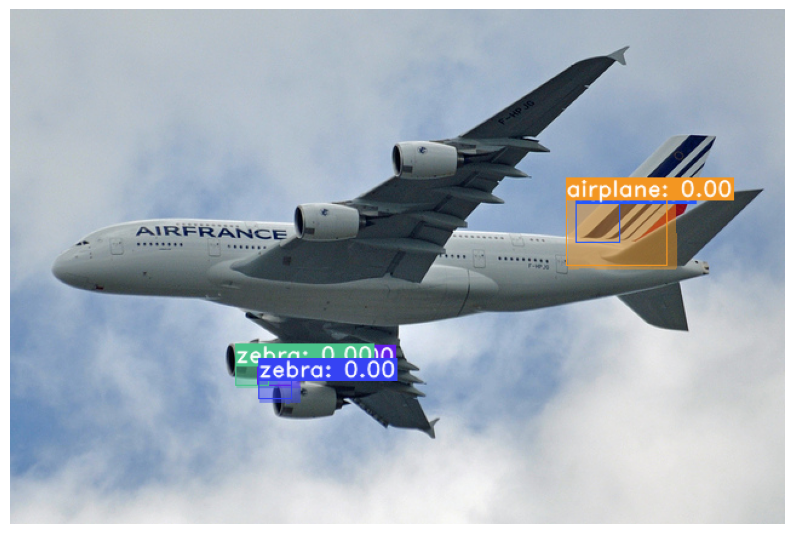

In [ ]:
cfg = test_yolact_config.copy()
img_numpy = prep_display(preds, image, None, None, undo_transform=False,
                         configuration=cfg)

plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(img_numpy);

**Output Processed**

```python
Box: torch.Size([PREDICTIONS*, 4])
Class: torch.Size([PREDICTIONS*])
Score: torch.Size([PREDICTIONS*])
Mask: torch.Size([PREDICTIONS*, IMAGE_HEIGHT*, IMAGE_WIDTH*])
```

In [ ]:
img_gpu = image / 255.0
h, w, _ = image.shape
classes, scores, boxes, masks = postprocess(preds, w, h, batch_idx=0, interpolation_mode='bilinear',
                                            visualize_lincomb=False, crop_masks=True, score_threshold=0,
                                            configuration=cfg)

print(f"Box Size: {boxes.size()}")
print(f"Class Size: {classes.size()}")
print(f"Score Size: {len(scores)}")
print(f"Mask Size: {masks.size()}")

print(f"\n\nBox Type: {boxes.type()}")
print(f"Class Type: {classes.type()}")
print(f"Score Type: {type(scores)} of {type(scores[0])}")
print(f"Mask Type: {masks.type()}")

print(f"\n\nBox:\n{boxes}")
print(f"\nClass:\n{classes}")
print(f"\nScore:\n{scores}")
print(f"\nMask:\n{masks}")

Box Size: torch.Size([100, 4])
Class Size: torch.Size([100])
Score Size: 2
Mask Size: torch.Size([100, 425, 640])


Box Type: torch.cuda.LongTensor
Class Type: torch.cuda.LongTensor
Score Type: <class 'list'> of <class 'torch.Tensor'>
Mask Type: torch.cuda.FloatTensor


Box:
tensor([[130619, 125564,    640,    425],
        [226065,  69501,    640,    425],
        [131442, 127894,    640,    425],
        [108246,  66507,    640,    425],
        [143231, 122927,    640,    425],
        [294317,  66937,    640,    425],
        [143096, 125656,    640,    425],
        [136793, 125733,    640,    425],
        [265164,  68886,    640,    425],
        [108732,  64120,    640,    425],
        [121022,  64211,    640,    425],
        [130314, 123000,    640,    425],
        [102529,  66547,    640,    425],
        [114543,  66614,    640,    425],
        [144287, 128116,    640,    425],
        [114780,  64101,    640,    425],
        [137174, 123030,    640,    425],
        [1

---